# Multi-Label Classification

This notebook will walk you through multi-label classification using the new API

First let's install our libraries

In [0]:
!pip3 install torch===1.3.0 torchvision===0.4.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/fastai/fastai_dev > /dev/null
!pip install Pillow --upgrade

Now let's grab what we need. For this particular one, we want `vision` and `data`

In [0]:
from fastai2.data.all import *
from fastai2.vision.all import *

For this multi-label problem, we will use the Planet dataset, where it's a collection of satellite images with multiple labels describing the scene. I'll go through and explain a few different ways to make this dataset, highlighting some of the flexibility the new `DataBlock` API can do. 

First, let's grab our data

In [0]:
planet_source = untar_data(URLs.PLANET_TINY)
df = pd.read_csv(planet_source/'labels.csv')

Now let's look at how it's stored. Our `DataFrame` is formatted so our images filename is the **first** column, and the labels in the **second**

In [4]:
df.head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


Awesome! So what can we do from here? Let's do the simplest method first. 

# Method 1 (the simplest)

In [0]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{planet_source}/train/', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '))

So I get we're creating that `PipeLine` thing, but what all is happening here? 
1. We expect our input to be an image (`ImageBlock`), and our outputs to be multi-category (`MultiCategoryBlock`) 
2. Next, we need to define how we want to grab our x's. To do so we will enlist a `ColReader`, which will read in the columns of a particular row (in our `DataFrame`, and we can attach both a prefix and a suffix to it. We want this in our case as our `image_name` column does not quite have the absolute path we need to find them. To account for this we'll include a prefix of the path to the `train` folder, and a suffix of the file type (.jpg)
3. We need to split our data, we'll just use our `RandomSplitter` again
4. We need to define how we want to get our `y` labels. We'll use a `ColReader` again to grab that second column, and declare that our multi-labels will be seperated by a space (' ')

From here, we can simply call our `.databunch()` function, pass in the values we want and our transforms and we create a `DataBunch`!

In [0]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
dbunch = planet.databunch(df, batch_tfms=batch_tfms)

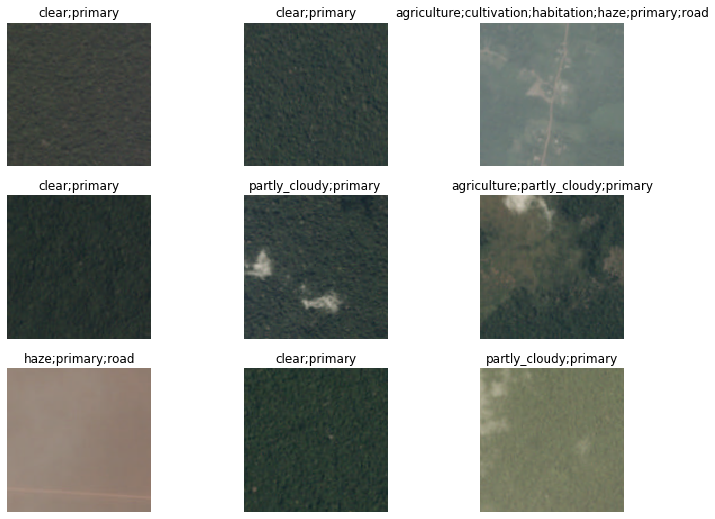

In [9]:
dbunch.show_batch(max_n=9, figsize=(12,9))

# Method 2: `Lambda`'s

This next version will instead use `lambda` functions to grab our image names, which get's rid of the `ColReader`, if you're more familiar with these

In [0]:
blocks = (ImageBlock, MultiCategoryBlock)

First let's try our `get_x`. Our lambda function needs to return a `Path()` to our particular image. This can be done by including `f'{x[0]}.jpg'` 

But what is that even doing? Let's take a look

In [0]:
get_x = lambda x:planet_source/'train'/f'{x[0]}.jpg'

If we pass in one row of our `DataFrame`, we should expect to see the entire path laid out in front of us!

In [12]:
val = df.values[0]; val

array(['train_31112', 'clear primary'], dtype=object)

In [13]:
get_x(df.values[0])

PosixPath('/root/.fastai/data/planet_tiny/train/train_31112.jpg')

Which it does! A nice, simple, and *clean* way to grab our paths. Let's see how our `y` getter will look like

In [0]:
get_y = lambda x:x[1].split(' ')

Looks fairly close to the previous version, if you pay attention. Remember that our `x` is the `DataFrame`'s values, so if we grab position 1 from earlier, we can see that it's our labels!

Let's make our full `PipeLine` now that we're sure everything will work

In [0]:
planet = DataBlock(blocks=blocks,
                   get_x=get_x,
                   splitter=RandomSplitter(),
                   get_y=get_y)

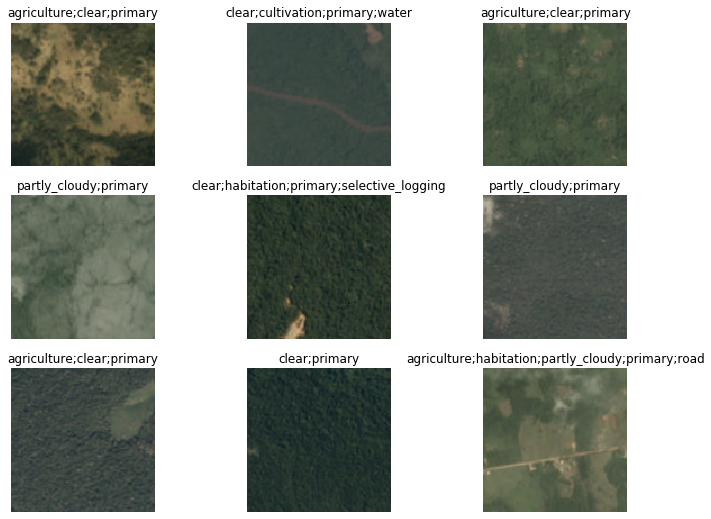

In [16]:
dbunch = planet.databunch(df, batch_tfms=batch_tfms)
dbunch.show_batch(max_n=9, figsize=(12,9))

It works! 

# Method 3: Custom `get_items` Functions

That previous one worked fine, but shouldn't I be able to do a one-liner? Since it's all right there instead of defining our `get_x` and `get_y`? There *IS*! We can create our own function, where we should expect to return both an `x` and a `y` value. Let's make one 

In [0]:
def _planet_items(x): return (
    f'{planet_source}/train/'+x.image_name+'.jpg', x.tags.str.split())

This is what we'd look like. Let's walk through what's happening. The first part of our touple is our `x`. When we pass in an `x` to our `get_items`, it will have two fields available to use, `image_name` and `targs`, both contain exactly what you'd expect. We can use `x.image_name` in where we had our `x` in the `lambda` earlier, and `targs` for the `x` in our function earlier too. We can also use a split string function to quickly break up our string by spaces

Our `DataBlock` now looks like so:

In [0]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items = _planet_items, 
                   splitter=RandomSplitter())

That's all our `DataBlock` needs if we can plan accordingly. Looks pretty clean!

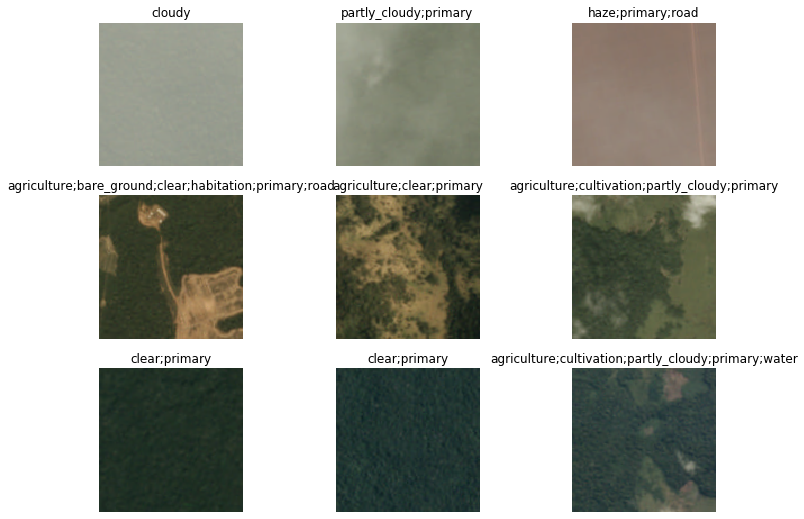

In [19]:
dbunch = planet.databunch(df, batch_tfms=batch_tfms)
dbunch.show_batch(max_n=9, figsize=(12,9))

# Method 4: As a `class`

The last option is to use a `class` declaration of a `DataBlock`. In it, we need to define our types of blocks, our splitter, and how we want to get our items as a `get_items` function. Let's see how that looks:

In [0]:
class PlanetDataBlock(DataBlock):
  blocks = ImageBlock, MultiCategoryBlock
  splitter = staticmethod(RandomSplitter())
  def get_items(self, x): return (
    f'{planet_source}/train/'+x.image_name+'.jpg', x.tags.str.split())

This has everything we need to make a `PipeLine`, all we have to do is call an instance of it to generate!

In [0]:
planet = PlanetDataBlock()

Now we can just `DataBunch` it and we're on our way!

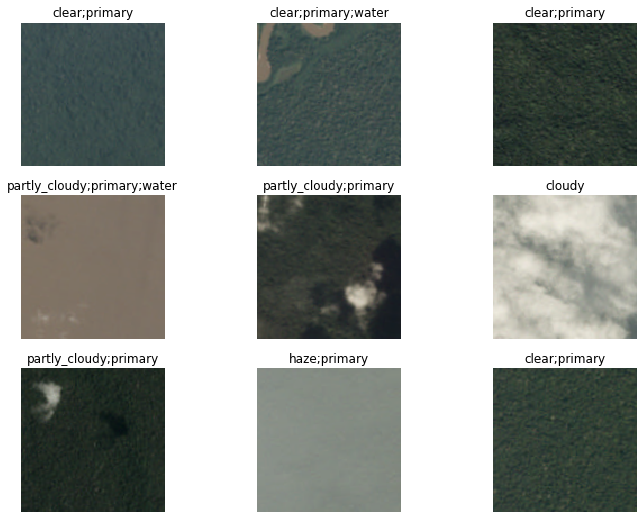

In [22]:
dbunch = planet.databunch(df, batch_tfms=batch_tfms)
dbunch.show_batch(max_n=9, figsize=(12,9))

There is **four** unique ways of dealing with the new `DataBlock` API for Multi-Label problems. Now let's train a model!

# Training a Model

We'll use a `resnet34` for this task

In [0]:
from torchvision.models import resnet34

We'll use `accuracy_multi` for multi-classificaiton

In [0]:
from fastai2.metrics import accuracy_multi

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=[accuracy_multi])

We'll find a good learning rate

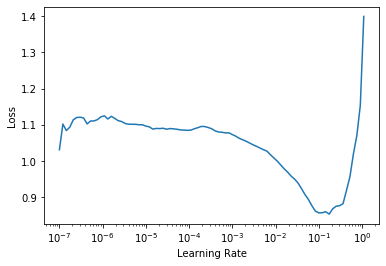

In [27]:
learn.lr_find()

And train! (we'll also used mixed precision too!)

In [0]:
lr = 1e-2

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.020474,0.915069,0.600000,00:01
1,0.864347,0.872738,0.676786,00:01
2,0.685383,0.478863,0.825000,00:01
3,0.551794,0.342282,0.878572,00:01
4,0.464799,0.298361,0.883929,00:01


Great! Let's save and `unfreeze` to train the rest of our model!

In [0]:
learn.save('stage-1')

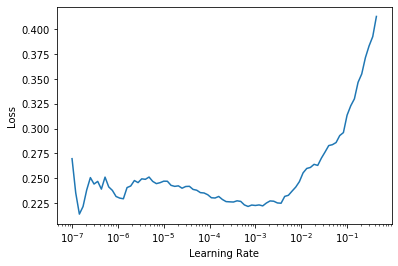

In [40]:
learn.unfreeze()
learn.lr_find()

We can now go through and use a learning rate around 1e-5 or so, and then have an ending learning rate five times smaller than our starting

In [41]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.259972,0.267827,0.883929,00:01
1,0.233580,0.273727,0.891071,00:01
2,0.219924,0.286746,0.889286,00:01
3,0.199335,0.292117,0.898214,00:01
4,0.194273,0.290360,0.894643,00:01


And we're done! Thanks for reading! :) 